### Gillespie algorithm for simulating kinesin walking on microtubules in vitro
MK Iwanski 2020-04-07

In [2]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as os

In [3]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [4]:
# parameters
mt_length = 100
nstep = 10**4

#rates of reactions
k_fwd = 3 #steps per sec
k_bck = 0 #steps per sec
k_on = 0.008 #0.002 #per dimer per sec
k_off = 0.05 #per sec

#update vectors for each reaction
nu_fwd = -1
nu_bck = -1
nu_on = 1
nu_off = -1

#update affinities of mt sites
alpha_max = 0.01 #maximal change in k_on (at site of motor)
#TO DO: assume this drops exponentially with number of sites away from motor and with time

In [5]:
def gillespie(X, t, m): #update time and state vectors (mt and affinity at site m)
   
    #generate random numbers
    rt = np.random.random()
    rr = np.random.random()
    
    #time to next reaction
    tau = np.log(1/rt)/k_tot
    
    #determine which reaction
    j = 0
    test = k[0]/k_tot
    while test<rr and j<len(k):#-1:
        j += 1
        test += k[j]/k_tot

    #pause()
    
    t += tau #update time
    X[m] += nu[j] #update state
    if m < mt_length-1 and X[m+1] == 0 and j == 0:
        X[m+1] -= nu[j] #update state of +1 site for forward step
    if m >  0 and X[m-1] == 0 and j == 1:
         X[m-1] -= nu[j] #update state of -1 site for back step
    
    return X, t

In [6]:
def affinity_update(aff, X, t_step): #update affinity based on motor positions
    
    aff = aff*np.exp(-t_step) #affinities decay with time back to baseline
    
    aff[X==1] = alpha_max #affinity at motor positions increase to max value
    
    motors = np.where(X==1)
    motors = np.asarray(motors, dtype=np.int)
    
    for k in range(0,motors.shape[1]):
    #for motor_loc in motors:
        motor_loc = motors[0,k]
        #if len(motor_loc) > 1:
            #print(motor_loc)
            #print(motors)
        #pause()
        for j in range(0,mt_length):
            if (motor_loc+j)<(mt_length-1):
                aff[motor_loc+j] += alpha_max*np.exp(-j)
            if (motor_loc-j)>=0:
                aff[motor_loc-j] += alpha_max*np.exp(-j)
        #TO DO: How to deal with overlapping effects...?
    
    aff[aff<0] = k_on
    aff[aff>alpha_max] = alpha_max
    
    return aff

In [7]:
#initialize
mt = np.zeros((nstep,mt_length), dtype=np.int)
affinity = np.zeros((nstep,mt_length))
affinity[:] = k_on
t = np.zeros(nstep)

#place motor(s) on MT to begin
for i in range(0,1):
    mt[0,np.random.randint(0,mt_length)] = 1

In [ ]:
#run Gillespie
for i in range(0,nstep-1):
    #choose MT lattice site
    m = np.random.randint(0,mt_length)
    #check current possible reactions
    if mt[i,m] == 1: #site is occupied
        k = [k_fwd, k_bck, 0, k_off]
        k_tot = np.sum(k)
        nu = [nu_fwd, nu_bck, 0, nu_off]
    else: #site is empty
        k = [0, 0, affinity[i,m], k_off] #k = [0, 0, k_on, k_off]
        k_tot = np.sum(k)
        nu = [0, 0, nu_on, 0]
        
    mt[i+1,:],t[i+1] = gillespie(mt[i,:],t[i],m)
    affinity[i+1,:] = affinity_update(affinity[i,:],mt[i+1,:],(t[i+1]-t[i]))
#pause() 

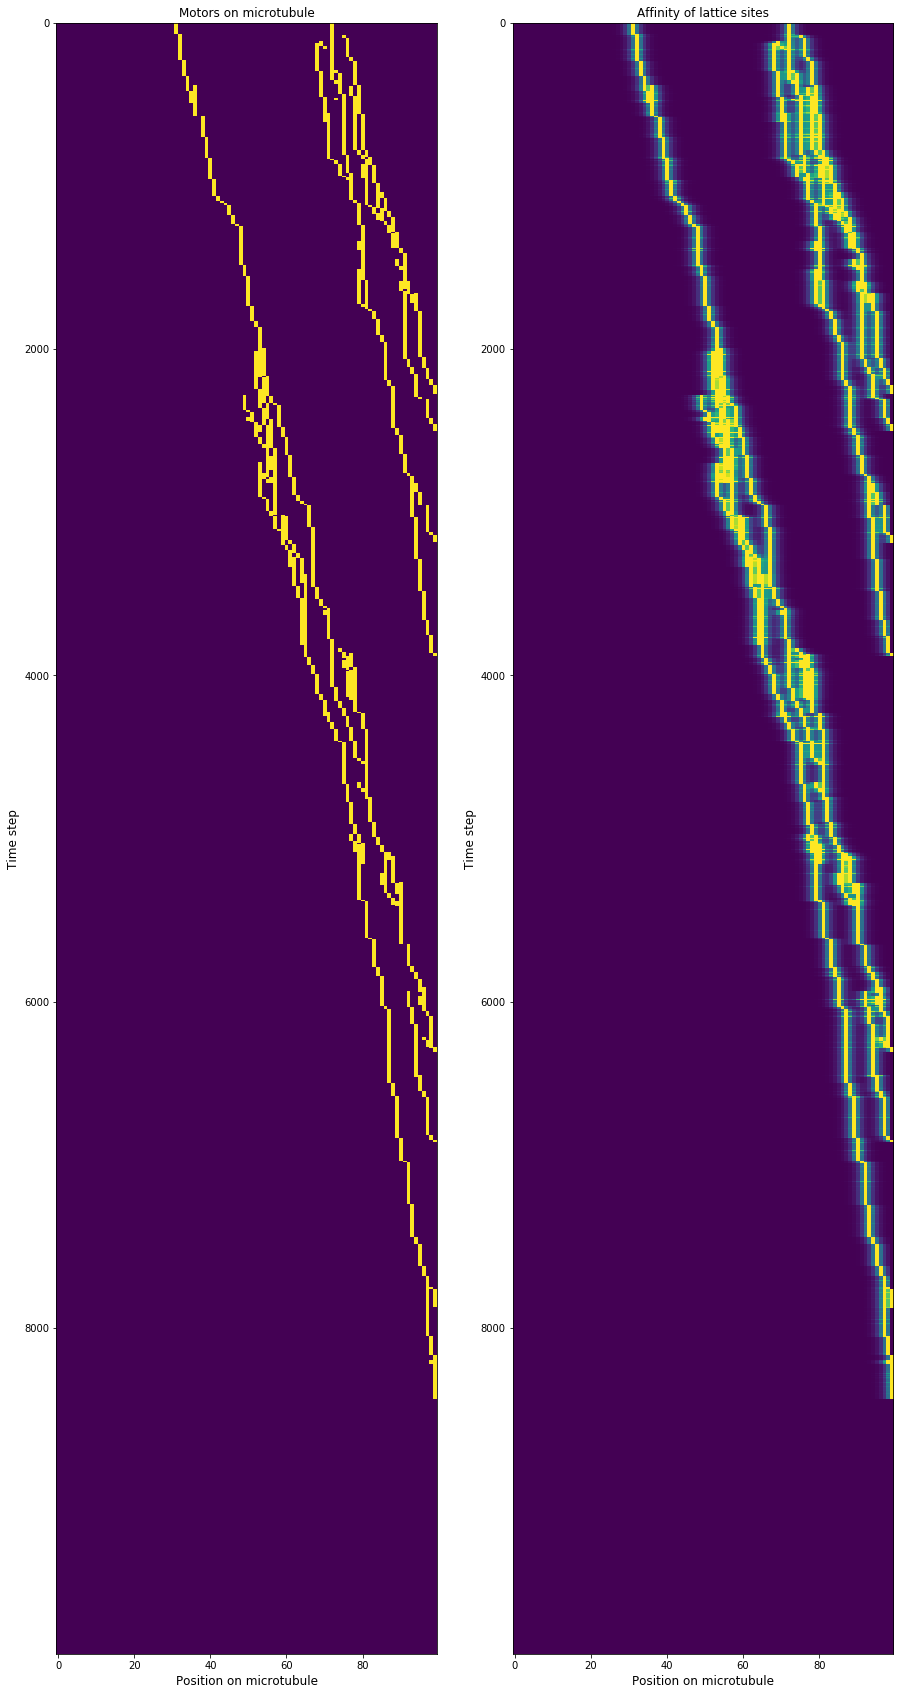

In [8]:
# plot results
fig, ax = plt.subplots(1,2, figsize=(15, 30))

ax[0].imshow(mt, cmap='viridis', aspect='auto', interpolation='nearest')
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)

ax[1].imshow(affinity, cmap='viridis', aspect='auto', interpolation='nearest')
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time step", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)

plt.show()

In [38]:
# save figs
save_dir = 'OneDrive - Universiteit Utrecht/Python/Temp_Figures/'
save_fname = 'Simulation_2020-04-07.png'
save_path = os.join(save_dir,save_fname)
plt.savefig(save_fname,format='png')

<Figure size 432x288 with 0 Axes>